In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, \
    Conv2DTranspose, MaxPooling2D, Dropout, \
    BatchNormalization, Activation, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from tensorflow.data import AUTOTUNE
from tensorflow import TensorSpec
from tensorflow import dtypes
from PIL import Image



In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Create a Project Directory
PROJECT_DIR = "/content/drive/MyDrive/camvid-semantic-segmentation"
if not os.path.exists(PROJECT_DIR):
    !mkdir {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/camvid-semantic-segmentation


In [ ]:
DATA_DIR = './data/CamVid'

# load repo with data if it doesn't exist
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# open a given image
def open_image(filename, num_channels=3):
    # open the given image
    with Image.open(filename) as img:
        if num_channels == 3:
            # convert to rgb
            img = img.convert("RGB")
        # return numpy array of image
        return np.asarray(img)

# crop a numpy array
def crop_data(height, width, image):
    cropped_data = image[:height, :width, :]
    return cropped_data

In [ ]:
# visualize an image, [mask, predicted mask]
def visualize(image_index, image, mask=None, pred_mask=None):
    # Set plot width to 5, 10 or 15 depending on
    # if a mask and/or predicted mask were given
    plot_width = 5
    if mask is not None:
        plot_width +=5
    if pred_mask is not None:
        plot_width += 5

    # Create a figure
    fig = plt.figure(figsize=(plot_width,3))

    # Add the image to the figure
    ax = fig.add_subplot(131)
    ax.imshow(image)
    ax.set_title("Image: %d" %(image_index,))

    # Add the mask to the figure
    if mask is not None:
        ax = fig.add_subplot(132)
        color_ax = ax.matshow(np.argmax(mask, axis=-1))
        ax.set_title("Ground Truth Mask")
        ax.xaxis.tick_bottom()

    # Add the predicted mask to the figure if it exists
    if pred_mask is not None:
        ax = fig.add_subplot(133)
        color_ax = ax.matshow(np.argmax(pred_mask.squeeze(), axis=-1))
        ax.set_title("Predicted Mask")
        ax.xaxis.tick_bottom()

    # Create a color bar
    fig.colorbar(color_ax)
    plt.show()


In [ ]:
# classes for data loading and preprocessing
class CamVidDataset(list):
    """CamVid Dataset. Read images, apply augmentation
    and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract
                             from segmentation mask
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']
    def __init__(
      self,
      images_dir,
      masks_dir,
      classes=CLASSES,
      height=352,
      width=480,
      batch_size=8,
      shuffle=True
    ):
      # get a list of image ids
      self.ids = os.listdir(images_dir)

      #get the paths of images and masks
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

      #convert str names to class values on masks
      self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

      #save height, width, batch size, and shuffle
      self.height = height
      self.width = width
      self.batch_size = batch_size
      self.shuffle = shuffle

      #create a list of indices for generator to loop through
      self.indices = np.arange(len(self.ids))
    
    def __getitem__(self,i):

      #read the image and mask from disk
      image = open_image(self.images_fps[i], 3)
      mask = open_image(self.masks_fps[i], 0)

      #extract certain classes from mask (e.g. cars)
      #create a list of one-hot encoded mask for each of the clases in class values
      masks = [(mask==v) for v in self.class_values]
      #convert to np array from list of masks
      mask = np.stack(masks, axis=-1).astype('float')

      #add background if mask is not binary
      if mask.shape[-1] != 1:
          # encode backgtound: 0 if any class in each pixel, else 1
          #since the classes are one-hot coded, use background = 1-sum
          background = 1-mask.sum(axis=-1, keepdims=True)
          #add the background mask to the stack of one-hot encoded masks
          mask = np.concatenate((mask, background), axis =-1)
      #crop image and mask
      image = crop_data(self.height, self.width, image)
      mask = crop_data(self.height, self.width, mask)

      return image, mask

    def __len__(self):
      return len(self.ids)

    def generate(self):
      #shuffle indices
      if self.shuffle:
        np.random.shuffle(self.indices)

        #for iterator calls__getitem__ to
        #return a pair of image and mask
      for index in self.indices:
        yield self[index]

    def get_generator(self):
      tfdatagen = Dataset.from_generator(
          #create a tf.Dataset generator using the generate method
          self.generate,
          #define output of the tf.Dataset generator
          output_signature =(
              #image shape and datatype
              TensorSpec((self.height, self.width, 3), dtypes.float32),
              #mask shape and datatype
              TensorSpec((self.height, self.width, len(self.class_values) +1), dtypes.float32))
          )

      return (tfdatagen
              # set the batch size
              .batch(self.batch_size)
              .prefetch(AUTOTUNE))

367
Image shape: (352, 480, 3)
Mask shape: (352, 480, 7)


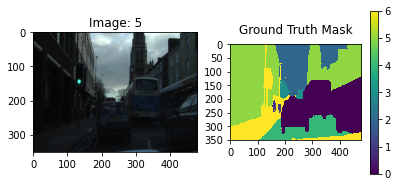

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [ ]:
CLASSES = ['car', 'pedestrian', 'sky', 'tree', 'road', 'building']
#we are using our classes
dataset = CamVidDataset(x_train_dir, y_train_dir,classes=CLASSES)

print(len(dataset))
image, mask = dataset[0]
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

image, mask = dataset[0]
visualize(5, image, mask)

#print each number and its class
#this will tell us what each color means
for i, the_class in enumerate(CLASSES):
  print(i, the_class)

In [ ]:
#define the batch size for training and validation
BATCH_SIZE = 8

#Define the input shape for our model to train on
#U-NET INPUT HEIGHT AND WIDTH MUST BE A FACTOR OF 16
INPUT_HEIGHT = 352
INPUT_WIDTH = 480

#DATASET FOR TRAIN IMAGES
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    height = INPUT_HEIGHT,
    width=INPUT_WIDTH,
    batch_size=BATCH_SIZE
)

#DATASET FOR validation IMAGES
valid_dataset = CamVidDataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    height = INPUT_HEIGHT,
    width=INPUT_WIDTH,
    batch_size=BATCH_SIZE
)

#create generators
train_generator = train_dataset.get_generator()
valid_generator = valid_dataset.get_generator()

In [ ]:
# u net and pathing

In [ ]:
#U- net block that will be used later in model building
def conv2d_block(input_layer, n_filters, kernel_size=3, batchnorm = True):
  x = input_layer
  for i in range(2):
    x = Conv2D(filters=n_filters,kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
      x = BatchNormalization()(x)
    x = Activation("relu")(x)
  return x

In [ ]:
def get_unet(input_layer, n_filters=16, dropout=0.5, batchnorm=True, use_transpose = True):
  x = input_layer
  #convs to keep track of the conv blocks
  convs = []
  #contracting path, apply a series of 4 convolution blocks
  for i in range(4):
    # apply a Conv2d Block
    x = conv2d_block(x, n_filters=n_filters*(2**i), kernel_size=3,batchnorm=batchnorm)
    
    convs.append(x)
    #downscale the tensore for every 2x2 into 1x1
    x = MaxPooling2D((2,2))(x)
    #apply dropout to avoid overfitting
    x = Dropout(dropout*(1, .5)[i==0])(x)
  #Base of the u-net
  x = conv2d_block(x, n_filters=n_filters*(2**4), kernel_size=3, batchnorm=batchnorm)

  #expansive path, apply a series of 4 up convolution blocks
  for i in range(3,-1,-1): #3,2,1,0
    #apply conv2dtranspose to upscale
    if use_transpose:
      x=Conv2DTranspose(n_filters*(2**i), (3,3),
                        strides = (2,2), padding='same')(x)
    else:
      x = Resizing(2*x.shape[1], 2*x.shape[2])(x)
    # add skip connection
    x = concatenate([x,convs[i]])
    #apply dropout to avoid overfitting
    x = Dropout(dropout)(x)
    #apply a Conv2D block
    x = conv2d_block(x, n_filters = n_filters*(2**i), kernel_size=3, batchnorm=batchnorm)

  outputs = Conv2D(n_filters, (1,1), activation='softmax') (x)
  model = Model(inputs = [input_layer], outputs=[outputs])
  return model


N_CHANNELS = 3
input_img = keras.Input((INPUT_HEIGHT, INPUT_WIDTH, N_CHANNELS),  name = 'img')
#create model
model = get_unet(input_img, n_filters = len(CLASSES) +1, dropout = 0.05, batchnorm = True, use_transpose=True)
model.compile(optimizer=Adam(), loss= "binary_crossentropy",metrics=["accuracy"])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 352, 480, 7)  196         ['img[0][0]']                    
                                                                                                  
 batch_normalization_36 (BatchN  (None, 352, 480, 7)  28         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 4

#Train model on dataset
#Model checkpoint will auto save the best model
#EarlyStopping will automatically stop when it stops improving
history = model.fit(x=train_generator, validation_data=valid_generator,epochs=EPOCHS, callbacks=[ModelCheckpoint(filepath='./ckpt.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1), EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)])

Epoch 1/4
     46/Unknown - 25s 360ms/step - loss: 0.6585 - accuracy: 0.1983
Epoch 1: val_accuracy improved from -inf to 0.19795, saving model to ./ckpt.hdf5
46/46 [==============================] - 30s 465ms/step - loss: 0.6585 - accuracy: 0.1983 - val_loss: 0.6496 - val_accuracy: 0.1980
Epoch 2/4
46/46 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.3641
Epoch 2: val_accuracy improved from 0.19795 to 0.45007, saving model to ./ckpt.hdf5
46/46 [==============================] - 19s 402ms/step - loss: 0.5656 - accuracy: 0.3641 - val_loss: 0.9206 - val_accuracy: 0.4501
Epoch 3/4
46/46 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.3959
Epoch 3: val_accuracy did not improve from 0.45007
46/46 [==============================] - 18s 391ms/step - loss: 0.5124 - accuracy: 0.3959 - val_loss: 0.5296 - val_accuracy: 0.3279
Epoch 4/4
46/46 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.4032
Epoch 4: val_accuracy did not im

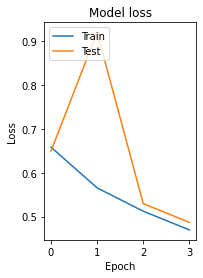

In [ ]:
#plot training
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
model.save_weights("ckpt.hdf5")
model.load_weights("ckpt.hdf5")

In [ ]:
test_dataset = CamVidDataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    height = INPUT_HEIGHT,
    width=INPUT_WIDTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#test data generator
test_generator = test_dataset.get_generator()

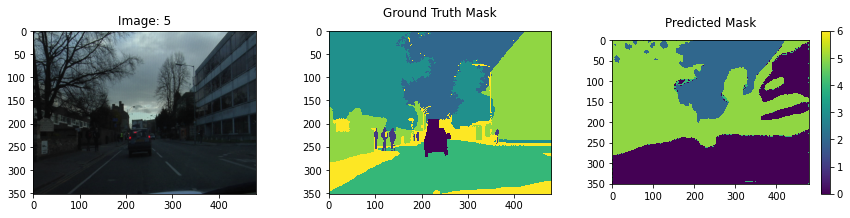

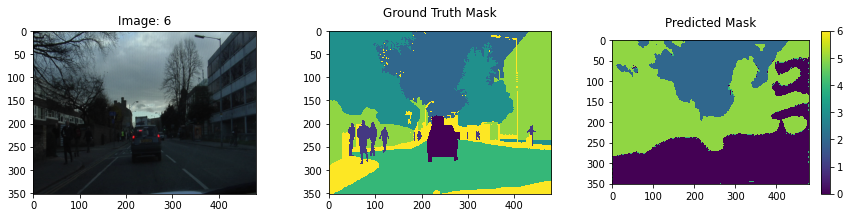

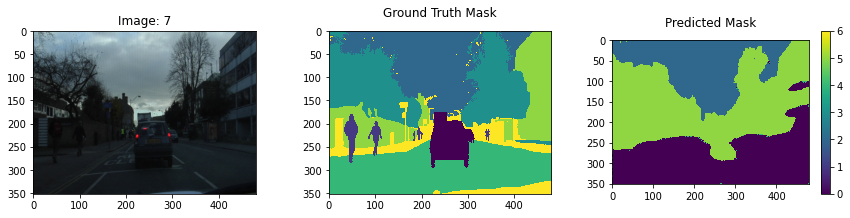

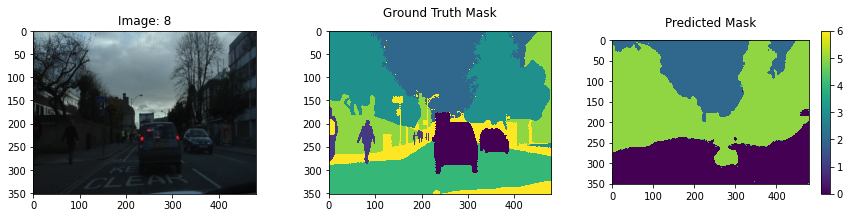

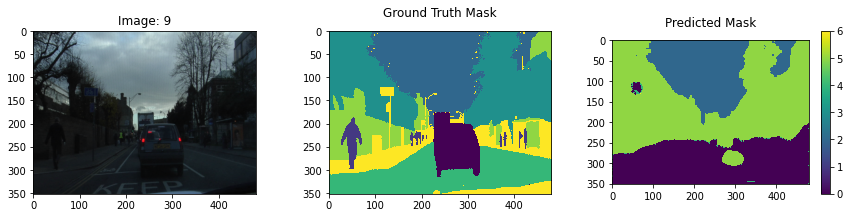

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [ ]:
# look at some random images at these indices
indices = [5,6,7,8,9]

for index in indices:
  image, gt_mask = test_dataset[index]
  image_array = np.expand_dims(image, axis =0).astype('float')
  pr_mask = model.predict(image_array)

  visualize(index, image, gt_mask, pr_mask)

for i, the_class in enumerate(CLASSES):
  print(i, the_class)

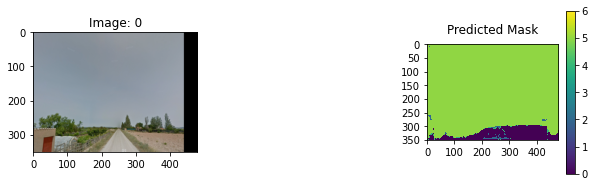

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [ ]:
#open and crop the image
image = open_image('strimgeight.png', 3)
cropped_image = crop_data(INPUT_HEIGHT,INPUT_WIDTH,image)

#create a batch of one
image_array = np.expand_dims(cropped_image, axis = 0).astype('float')

#generate predicted mask
pr_mask = model.predict(image_array)

#visualize image and predicted mask
visualize(0, cropped_image, None, pr_mask)

#output color/class mappings
for i, the_class in enumerate(CLASSES):
  print(i, the_class)

#model.evaluate(test_generator)


In [ ]:
y_hat = model.predict(test_generator)
y_hat = np.argmax(y_hat, axis =-1)
y_hat = y_hat.flatten()

y_real = np.array([item for batch in test_generator for item in batch[1]])
y_real = np.argmax(y_real, axis =-1)
y_real = y_real.flatten()
 


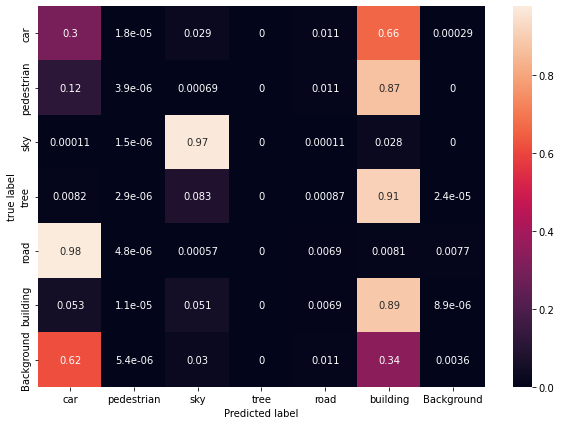

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(confusion_matrix(y_real, y_hat, normalize="true"),
                     index = CLASSES + ["Background"],
                     columns = CLASSES + ["Background"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True)

plt.xlabel("Predicted label")
plt.ylabel("true label")
plt.show()